# View Landsats Imagery with PQ25 mask


| Author(s):  |  Bex Dunn, Mike Barnes, Claire Krause, Damien Ayers, Arapaut Sivaprasad|
|----------|----------------|
| Created (adapted): | May 08, 2018 |
| Last Modified: | May 18, 2018 |


**Background:** Data from three Landsats (5,7 and 8) are available to access within DEA. The data can be plotted after applying selective masks based on pixel quality (PQ25). The code snippets in this doc will let you retrieve the data, mask by using PQ and then plot for **lsN_nbar_albers** and **lsN_nbart_albers**, where N is 5, 7 or 8 to denote the satellite.

**What does this document do?**

- Show how to open a datacube to retrieve the data for various time points and geo-coordinates.

- Extract the PQ data to be used as mask.

- Display the masking flags as a plot.

- Show the description of flags in a table.

- Apply the mask and plot.


**How to use this document:**

A basic understanding of *any* programming language is desirable, so that the code will make sense, but one doesn't have to be an expert Python programmer to manipulate the code to get and display the data. 

Quoted text from external sites/documents are linked to the **References** section, shown as **[n]** were **n** refers to the references list index, which in turn links to the original publication. 

This doc applies to the following Landsats and data correction methods:

- Landsat 5
- Landsat 7
- Landsat 8
- NBAR
- NBAR-T

## What is PQ25? [[1](#References)]
"The PQ25 product is designed to facilitate the interpretation and processing of 
the Australian Reflectance Grid 25 (ARG25) and Fractional Cover 25 (FC25) products." 

"It is a classification that represents an assessment of whether an image
pixel represents an unobscured unsaturated observation of the Earth's surface and whether 
the pixel is represented in each spectral band. The PQ product allows users to produce
masks which can be used to exclude  affected pixels which don't meet their quality 
criteria from further analysis. The capacity to automatically exclude such pixels from 
analysis is essential for emerging multi-temporal analysis techniques that make use of every 
quality assured pixel within a time series of observations."


"PQ25 provides an assessment of the quality of observations at a pixel level, and contains information about whether a pixel is affected by the following."

- Spectral Contiguity (lack of signal in any band)
- Saturation in any band
- Presence of cloud
- Presence of cloud shadow
- Being offshore (sea)


## Step-by-step instructions
Let us go through the process step by step.

### 1. Import modules and libraries
All the modules and libraries below are standard ones available to all users. 

In [96]:
%matplotlib inline

import matplotlib.pyplot as plt
import datacube
from datacube.storage import masking
from datacube.storage.storage import write_dataset_to_netcdf

import xarray as xr
import numpy as np
import os
import rasterio

from datacube.helpers import ga_pq_fuser
print(dir(ga_pq_fuser))
print(ga_pq_fuser.__doc__)

dc = datacube.Datacube(app='dc-plot landsat  FalseColour')

['__annotations__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']

    Fuse two Geoscience Australia Pixel Quality ndarrays

    To be used as a `fuse_func` when loaded `grouped` data, for example when grouping
    by solar day to avoid duplicate data from scene overlaps.
    


### 2. The datacube query

**Edit the start and end dates and spatial bounds here if you wish**

The date range determines the number of scenes to be retrieved. About 16 days form one scene.

In [84]:
#Create query
query = {'time': ('2015-09-01', '2015-09-15')}
query['x'] = ('149.05', '149.17')
query['y'] = ('-35.25', '-35.35')

# Define the plot size. The dimensions will be multiplied with 72 pixels. Thus, 10,10 = 720 x 720px
figsize=[10, 10]

### 3. Run the datacube extraction
**This may take some time. Be patient!**

The next two blocks of code are to extract the data.


**Now, we get the data (in the variable, ds) which will be used by the plotting functions later. **

In the load command below, we are getting the data from 'ls8_nbar_albers' for the specified date range and geo-coordinates. If there are more than one picture on a day, they are combined into one by the group_by='solar_day' parameter. 

During this process of making a composite picture, we need to make sure that the data integrity is maintained. By default, data is simply copied over the top of each other, in a relatively undefined manner. This 'fuse_func' can perform a specific combining step, to avoid duplicate data from scene overlaps. It is used here so that the PQ masking (see later) will be more accurate.

In [85]:
ds = dc.load(product='ls8_nbar_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
ds

<xarray.Dataset>
Dimensions:          (time: 1, x: 492, y: 500)
Coordinates:
  * time             (time) datetime64[ns] 2015-09-06T23:56:19.500000
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) int16 1964 1809 3075 3487 4269 4679 5040 ...
    blue             (time, y, x) int16 1861 1602 2859 3208 3925 4474 4908 ...
    green            (time, y, x) int16 1794 1740 3353 3709 4506 4936 5371 ...
    red              (time, y, x) int16 1840 1721 3264 3613 4570 5129 5660 ...
    nir              (time, y, x) int16 2685 2572 3861 4274 5160 5695 6149 ...
    swir1            (time, y, x) int16 2068 2134 3486 3937 4730 5280 5828 ...
    swir2            (time, y, x) int16 1559 1568 2714 3162 3922 4478 5025 ...
Attributes:
    crs:      EPSG:3577

### 4. Extract the PQ data to be used as mask. 
If pixel quality filtering is enabled, extract the PQ data to be used as mask. This is stored in exactly the same format as the main data, but will be used to mask the selected pixels. 

If the cloud covered regions are masked, by setting 'no_cloud' to both cloud_acca and cloud_fmask, then values of those pixels will be set as 'NaN'. On the other hand, if you set 'cloud' you will see the clouds and nothing else.

In [86]:
sensor_pq = dc.load(product='ls8_pq_albers', group_by='solar_day', **query)
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 cloud_fmask='no_cloud',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)

#### Masking of pixels explained [[1](#References)]
Based on the property of the pixels, as set above and described in the table below, we can selectively mask some to improve the visualisation.
- **Saturated**: means this band has exceeded the dynamic range of the sensor. The data cannot be trusted.
    - When it is specified as e.g. blue_saturated=False, it asks to show the pixel only if it is not saturated. If set as True, it will mask ALL pixels that are not saturated for the Blue band. 
    - The purpose of this mask is to find areas where the reflectance has exceeded the dynamic range of the sensors. e.g. a bright light from reflections on water surface may saturate the pixels.
    - Generally, setting any bands as 'saturated=True' will resulty in a black rectangle instead of showing any picture.
- **algorithms:** to detect clouds which obstruct and/or distort the data.
    - ACCA: Automated Cloud Cover Assessment
    - Fmask: Function of mask
        - ACCA is already widely used within the remote sensing community; it is fast and relatively accurate.  Fmask on the other hand is newer, but is rapidly becoming more established, and can provide a more accurate cloud mask than ACCA in certain cloud environments.
        - As in the case of the saturated mask, a mask for cloud will do the same. e.g. 'cloud_acca=no_cloud' means that the pixels under a cloud are masked, but all others are displayed. If set as True, only those under cloud are shown and others masked. For some unknown reason, you must set both algorithms to see an effcet. In other words, if set **cloud_acca='cloud'** and **cloud_fmask='cloud'**, then you will see only the clouds and nothing around it.
       
The different masks and their bit values can be seen in the table below. Note: The setting of bits as True/False are in reverse order, such that True=0 and False=1, which is confusing to the first-time user. But, if you stop to think about it, it makes sense that 'saturated=False' is the same as 'not_saturated=True'. It is unknown why the mask flags are not named as e.g. 'blue_not_saturated=True' instead of 'blue_saturated=False'.
  
      


In [87]:
dvf = masking.describe_variable_flags(sensor_pq)
dvf

,bits,values,description
blue_saturated,0,"{'0': True, '1': False}",Blue band is saturated
cloud_acca,10,"{'0': 'cloud', '1': 'no_cloud'}",Cloud (ACCA)
cloud_fmask,11,"{'0': 'cloud', '1': 'no_cloud'}",Cloud (Fmask)
cloud_shadow_acca,12,"{'0': 'cloud_shadow', '1': 'no_cloud_shadow'}",Cloud Shadow (ACCA)
cloud_shadow_fmask,13,"{'0': 'cloud_shadow', '1': 'no_cloud_shadow'}",Cloud Shadow (Fmask)
contiguous,8,"{'0': False, '1': True}",All bands for this pixel contain non-null values
ga_good_pixel,"[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",{'16383': True},Best Quality Pixel
green_saturated,1,"{'0': True, '1': False}",Green band is saturated
land_sea,9,"{'0': 'sea', '1': 'land'}",Land or Sea
nir_saturated,3,"{'0': True, '1': False}",NIR band is saturated


### 5. See how the mask looks like
We set the masks for 'good_quality' as 'no_cloud' for both 'acca' and 'Fmask' algorithms. The plot below shows these masked pixels as maroon and unmasked ones as yellow. When the plot is created they will appear as black and original colors, respectively.

In [88]:
good_quality

<xarray.DataArray 'pixelquality' (time: 1, y: 500, x: 492)>
array([[[False, False, ...,  True,  True],
        [False, False, ...,  True,  True],
        ...,
        [False, False, ...,  True,  True],
        [False, False, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 2015-09-06T23:56:19.500000
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...

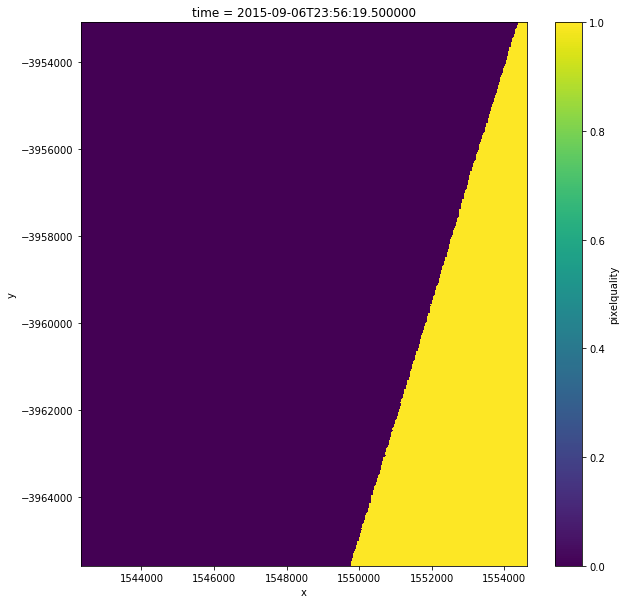

In [89]:
fig = plt.figure(figsize=figsize)
good_quality.plot();  # The semi-colon prevents the display of unwanted lines

### 6. Apply the mask to the data
The code below will mask the specified pixels by setting their data points to NaN. In this case, all pixels of cloud will become NaN.

In [90]:
# Apply the mask to preserve only the good data
ds = ds.where(good_quality)
ds

<xarray.Dataset>
Dimensions:          (time: 1, x: 492, y: 500)
Coordinates:
  * time             (time) datetime64[ns] 2015-09-06T23:56:19.500000
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 nan nan nan nan nan nan nan nan ...
    blue             (time, y, x) float64 nan nan nan nan nan nan nan nan ...
    green            (time, y, x) float64 nan nan nan nan nan nan nan nan ...
    red              (time, y, x) float64 nan nan nan nan nan nan nan nan ...
    nir              (time, y, x) float64 nan nan nan nan nan nan nan nan ...
    swir1            (time, y, x) float64 nan nan nan nan nan nan nan nan ...
    swir2            (time, y, x) float64 nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577

### 7. Create the image data to plot

In [91]:
time=0
bands = ['nir', 'swir1', 'swir2']
t, y, x = ds[bands[0]].shape
rawimg = np.zeros((y, x, 3), dtype=np.float32)
for i, colour in enumerate(bands):
    rawimg[:, :, i] = ds[colour][time].values
img_toshow = (rawimg / 5000).clip(0, 1)

### 8. Plot the image

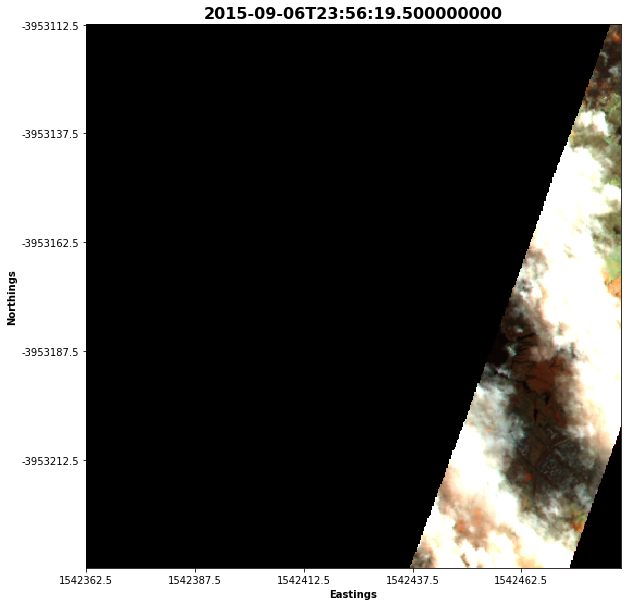

In [92]:
np.seterr(divide='ignore', invalid='ignore') # This eliminates a RuntimeWarning if there is a divide by zero or NaN
fig = plt.figure(figsize=figsize)
plt.imshow(img_toshow)
ax = plt.gca()
ax.set_title(str(ds.time[time].values), fontweight='bold', fontsize=16)

ax.set_xticklabels(ds.x.values)
ax.set_yticklabels(ds.y.values)
ax.set_xlabel('Eastings', fontweight='bold')
ax.set_ylabel('Northings', fontweight='bold'); # The semi-colon prevents the display of unwanted lines

## References
1. GA, 2015. *Pixel Quality (PQ25) Product Description* https://d28rz98at9flks.cloudfront.net/81942/Pixel_Quality_PQ25.PDF